# Set up 


In [3]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import sys
import scipy.optimize as optimize
import threading
# from rpy2.robjects.packages import importr, data
# from rpy2.robjects.lib.dplyr import DataFrame
from datetime import datetime


In [4]:
path="./" + "sidedata/"
filename = path + "Alldata2.csv"

df=pd.read_csv(filename, index_col=None)
df['Probtype'] = np.where(df['Stimkind']==1, "CM",
                   np.where(df['Stimkind']==0, "AN",
                   np.where(df['Stimkind']==3, 'VM',"wrong")))

df['Oldnew'] = np.where(df['Old']==1, "old",
                   np.where(df['Old']==2, "new","wrong"))
df['Error'] = 1-df['Correctness']
df_org = df[df['RT']<2000]
df = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","Error","FileCondi"])[["RT"]].agg(["mean"])
# df[["Correctness","Error"]]
# df.groupby("Error")
df.index.name = 'Setsize'
df.reset_index(inplace=True)
# df["Error"]


df_err = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["Error"]].agg(["mean"]).reset_index()
df_crt = df_org[df_org["Error"]==0].\
groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["RT"]].agg(["mean"]).reset_index()

df_err.columns = df_err.columns.droplevel(1)
df_crt.columns = df_crt.columns.droplevel(1)

# df_err.reindex(np.arange(1,df_err.shape[0]))
# df_crt.reindex(np.arange(1,df_crt.shape[0]))

# Parameter set

In [5]:
global boost, alpha, beta, s, c ,Old_crit ,New_crit ,\
    t0 ,kao , F, L
  
alpha={}; beta ={}; s = {}; F = {}; L = {}; t0 = {}


boost = 1.05
alpha["all"] = 0.19
# alpha['CM'] = 0.1969 
# alpha['VM'] = 0.1969 
# alpha["AN"]=0.84

beta["all"] =1.2
# beta['CM'] = 1.228
# beta['VM'] = 1.228
# beta["AN"]= 1.708

s["all"]=0.01
# s["AN"] = 0.01
# s["CM"] = 0.02
# s["VM"] = 0.02
c = 0.3938

Old_crit = 1.9197
New_crit = -2.33
t0["all"] = 699.98
t0["new"] = 699.98

kao = 37

#---CM
F["CM_oldiold_oldinew"] = 0.2

L["CM_oldiold_newinew"] = 0.2
L["CM_oldinew_newiold"] = 0.2

#---AN
F["AN_oldiold_oldinew"] = 0.2

# Assign LTM global

In [6]:
def assign_LTM_global(item_condi, walk, item):
    
    global F,L,Fnow,Lnow
    
    if item_condi=="CM":
        
        if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":
            
            Fnow = F["CM_oldiold_oldinew"]
        else: Fnow = 0
        
        if walk+"i"+item == "oldiold" or walk+"i"+item == "newinew":
            
            Lnow = L["CM_oldiold_newinew"]
        elif walk+"i"+item == "oldinew" or walk+"i"+item == "newiold":
            
            Lnow = L["CM_oldinew_newiold"]
        else: Lnow=0
            
    if item_condi == "AN":
        
        if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":
            
            Fnow = F["AN_oldiold_oldinew"]
        else: Fnow=0
        
        Lnow = 0
    
    return(Fnow + Lnow)

assign_LTM_global("CM","new","old")
        

0.2

# Calc A (activation)

In [7]:
# seperate albes
def calcA(df, name):

    
    dnow = df[df['FileCondi']==name]
    a = np.zeros((dnow.shape[0], 8))  #activation
    
    snow=s["all"]
    betanow=beta["all"] 
    alphanow=alpha["all"]
    
    m = np.array([(j**(-betanow) + alphanow) for j in np.arange(1,9)])
    
    for j in range(1,9):
        
        indexj = j-1
        a[dnow["Lag"]!=j,indexj] = m[indexj] * s["all"]
        a[dnow["Lag"]==j,indexj] = m[indexj]
        
#         print(m[indexj] * s["all"])
    for i in range(a.shape[0]): a[i,dnow['Setsize'].iloc[i]:] = 0 #a_ij suit for the correct amount of setsize
    debug = 0
    if debug==1:
        for i in range(a.shape[0]):
            print(i, "begin\n","a is",a[i].round(5),\
                  "\n m is", np.array(m).round(3),"\n Probtype is",\
                  "\n Lag is ",dnow['Lag'].iloc[i],\
                  "\n Setsize is", dnow["Setsize"].iloc[i],\
                  "\n Probtype:",\
                  dnow["Probtype"].iloc[i],\
                  "\n Oldnew: ",dnow["Oldnew"].iloc[i],\
                  "\n Ai is", a[i,:].sum().round(2),\
                  "\n snow", snow,\
                 "\n------------------------------------------------" )

    
    A = a.sum(axis = 1)
    
    return(A)

print(calcA(df[df["Error"]==0], "CMat"))


[0.01815275 0.01815275 0.0265232  0.0265232  0.03853018 0.03853018
 1.19625275 0.63717528 1.19625275 0.63717528 1.2046232  0.64554573
 0.47952792 0.40219313 1.2046232  0.64554573 0.47952792 0.40219313
 1.21663018 0.65755271 0.4915349  0.41420011 0.37013656 0.34193666
 0.32246373 0.30827473 1.21663018 0.65755271 0.4915349  0.41420011
 0.37013656 0.34193666 0.32246373 0.30827473]


# Calc p (drift rate)

In [8]:

def calcp(df, name):
    
    A = calcA(df, name)
    dnow = df[df['FileCondi']==name]
    p = np.repeat(3.0, A.shape[0])
    
    probs = dnow["Probtype"].astype("category").cat.categories.to_numpy() #get categories name
    

    for iprob in probs:
        
        for ion in ["old","new"]:
            
            tf_ion = dnow['Oldnew'] == ion
            tf_iprob = dnow['Probtype'] == iprob
            tf_all = np.logical_and(tf_ion, tf_iprob)
            
            IR_old_current = assign_LTM_global(iprob,"old",ion)
            IR_new_current = assign_LTM_global(iprob,"new",ion)
        
            p[tf_all] = (A[tf_all] + IR_old_current)/(A[tf_all] + IR_old_current + c + IR_new_current)
        
#             print("**","MIX",iprob,"oldi"+ion+"--",IR_old_current,
#                                       "newi"+ion+"--",IR_new_current, p[tf_all])
    return(np.array(p))

p0=calcp(df,"MIX")

# ok1=calcp(df, "MIX")
# on = df[df['FileCondi']=="MIX"]["Oldnew"]
# onn = df[df['FileCondi']=="MIX"]["Probtype"]
# ss = df[df['FileCondi']=="MIX"]["Setsize"]
# lagg = df[df['FileCondi']=="MIX"]["Lag"]
# # print(np.array([str(ok1[i].round(2))+"-"+str(on.iloc[i]) for i in range(ok1.shape[0])]))
# print(np.array([str(ok1[i].round(8))+"-"+str(on.iloc[i]) +"-"+str(onn.iloc[i])+"-ss:"+str(ss.iloc[i])\
#                 + "-lag:" + str(lagg.iloc[i]) for i in range(ok1.shape[0])]))

# dd = df[df['FileCondi']=="MIX"]
# A0=calcA(df,"MIX")
show =[dd["FileCondi"].iloc[i]+\
       "--"+dd["Probtype"].iloc[i]+\
       "--"+ dd["Setsize"].iloc[i].astype(str)+\
       "--"+dd["Oldnew"].iloc[i]+\
       "-- "+p0[i].round(5).astype(str) for i in range(p0.size)]
print(np.sort(show))


NameError: name 'dd' is not defined

# RW 

In [10]:

def calc_theoretical_RW(df, which, name):

    A = calcA(df, name)
    p = calcp(df, name)

#     dnow
    dnow = df[df['FileCondi']==name]

    p_resp_old = np.zeros(p.size)
    pred_correct = np.zeros(p.size)

    q = 1-p

    AA = Old_crit
    BB = -New_crit # bb is a postive number

    exp_nstep = np.zeros(p.shape[0])

    
    theta1 = ((p/q)**(AA+BB)+1)/((p/q)**(AA+BB)-1)
    theta2 = ((p/q)**BB+1)/((p/q)**BB-1)

    
    tf = np.logical_and(p!=q , dnow["Oldnew"]=='old')
    exp_nstep[tf] = (1/(p[tf]-q[tf]))*(theta1[tf]*(AA+BB) - theta2[tf]*BB)
    
    tf = np.logical_and(p==q , dnow["Oldnew"]=='old')
    exp_nstep[tf] = (AA/3)*(2*BB+AA)
    
    #-------------------
    theta1 = ((p/q)**(-(AA+BB))+1)/((p/q)**(-(AA+BB))-1)
    theta2 = ((p/q)**-AA+1)/((p/q)**-AA-1)

    tf = np.logical_and(p!=q , dnow["Oldnew"]=='new')
    exp_nstep[tf] = (1/(q[tf]-p[tf]))*(theta1[tf]*(AA+BB) - theta2[tf]*AA)
    tf = np.logical_and(p==q , dnow["Oldnew"]=='new')
    exp_nstep[tf] = (BB/3)*(2*AA+BB)
    
    
    p_resp_old[p!=q] = ((1-(q/p)**BB)/(1-(q/p)**(AA+BB)))[p!=q]
    p_resp_old[p==q] = BB/(AA+BB)
    
    pred_correct[dnow["Oldnew"]=='old'] = p_resp_old[dnow["Oldnew"]=="old"]
    pred_correct[dnow["Oldnew"]=="new"] = 1-p_resp_old[dnow["Oldnew"]=="new"]
    
    pred_rt = t0 + kao * exp_nstep
    


    return(np.array(pred_rt), np.array(pred_correct))
          

# df_sub_err = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["Error"]].agg(["mean"]).reset_index()


# ok1=calcp(df_sub_err, "MIX")
# on = df_sub_err[df_sub_err['FileCondi']=="MIX"]["Oldnew"]
# onn = df_sub_err[df_sub_err['FileCondi']=="MIX"]["Probtype"]
# # print(np.array([str(ok1[i].round(2))+"-"+str(on.iloc[i]) +"-"+str(onn.iloc[i]) for i in range(ok1.shape[0])]))

# jjj, ok1 =calc_theoretical_RW(df_sub_err, "MIX")
# on = df_sub_err[df_sub_err['FileCondi']=="MIX"]["Oldnew"]
# onn = df_sub_err[df_sub_err['FileCondi']=="MIX"]["Probtype"]
# one = (df_sub_err[df_sub_err['FileCondi']=="MIX"][[("Error","mean")]]).to_numpy().round(3)

# # print(np.array([str((ok1[i]).round(2))+"-"+str(on.iloc[i])+"-"+str(onn.iloc[i]) for i in range(ok1.shape[0])]))

# np.array([str(one[i])+"-"+str(on.iloc[i])+"-"+str(onn.iloc[i]) for i in range(ok1.shape[0])])


dd = df[df['FileCondi']=="CMpure"]
crt,err =calc_theoretical_RW(dd,"CMpure")
show =[dd["FileCondi"].iloc[i]+\
       "--"+dd["Probtype"].iloc[i]+\
       "--"+ dd["Setsize"].iloc[i].astype(str)+\
       "--"+dd["Oldnew"].iloc[i]+\
       "-- "+err[i].round(5).astype(str) for i in range(err.size)]
print(np.sort(show))
show =[dd["FileCondi"].iloc[i]+\
       "--"+dd["Probtype"].iloc[i]+\
       "--"+ dd["Setsize"].iloc[i].astype(str)+\
       "--"+dd["Oldnew"].iloc[i]+\
       "-- "+crt[i].round(5).astype(str) for i in range(crt.size)]

TypeError: unsupported operand type(s) for +: 'dict' and 'float'

# Calculate WSSE

In [9]:
w={}
w["new_rt"] = 4*2
w["old_rt"] = 1*2
w["new_err"] = 4
w["old_err"] = 1

def calc_wssd(df, name):

    df_sub_org = df[df["FileCondi"] == name]
    df_sub_err = df_err[df_err["FileCondi"] == name]
    df_sub_crt = df_crt[df_crt["FileCondi"] == name]

    df_sub_err = df_sub_err.reset_index()
    df_sub_crt = df_sub_crt.reset_index()

    pred_rt, pred_correct = calc_theoretical_RW(df_sub_err, name)
    pred_crt, pred_ccorrect = calc_theoretical_RW(df_sub_crt, name)

    pred_rt, pred_correct = calc_theoretical_RW(df_sub_err, name)
    pred_crt, pred_ccorrect = calc_theoretical_RW(df_sub_crt, name)

    df_sub_crt["pred_crt"] = pred_crt/1000 #translate crt to seconds. 
    df_sub_err["pred_error"] = 1- pred_correct

    df_sub_crt["RT"]= df_sub_crt["RT"]/1000

    df_sub_crt["SSD_RT"] = ((df_sub_crt["RT"] - df_sub_crt["pred_crt"])**2).to_numpy()
    df_sub_err["SSD_err"] = ((df_sub_err["Error"] - df_sub_err["pred_error"])**2).to_numpy()

    df_sub_crt["wSSD_RT"] = [df_sub_crt.loc[i,"SSD_RT"] *\
                             w[df_sub_crt.loc[i,"Oldnew"]+"_rt"] for i in range(df_sub_crt.shape[0])]

    df_sub_err["wSSD_err"] = [df_sub_err.loc[i,"SSD_err"] *\
                             w[df_sub_err.loc[i,"Oldnew"] + "_err"] for i in range(df_sub_err.shape[0])]

    WSSD = df_sub_err["wSSD_err"].sum() + df_sub_crt["wSSD_RT"].sum()

    return(WSSD)

time1=time.time()
calc_wssd(df_org, "MIX")
print(time.time()-time1)
# df_sub_agg, WSSD = calc_wssd(df, "MIX")

NameError: name 'calc_theoretical_RW' is not defined

# Parameter search

## Asign parm_dic

In [9]:
param_dic=np.array((
    
    alpha["all"],
    beta["all"],
    s["all"],
    
    c,
    
    Old_crit,
    New_crit,
    
    t0,
    kao,

    #---CM
    F["CM_oldiold_oldinew"],

    L["CM_oldiold_newinew"],
    L["CM_oldinew_newiold"],

    #---AN
    F["AN_oldiold_oldinew"]
))
param_dic

array([ 1.9000e-01,  1.2000e+00,  1.0000e-02,  3.9380e-01,  1.9197e+00,
       -2.3300e+00,  6.9998e+02,  3.7000e+01,  2.0000e-01,  2.0000e-01,
        2.0000e-01,  2.0000e-01])

## optim_wsse

In [10]:
def optim_wsse(params_dic):
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
        t0 ,kao ,F, L

    alpha={}; beta ={}; s = {}; F = {}; L={}
    
    # print(params)  # <-- you'll see that params is a NumPy array
    [
        alpha["all"],
        beta["all"],
        s["all"],

        c,

        Old_crit,
        New_crit,

        t0,
        kao,

        #---CM
        F["CM_oldiold_oldinew"],

        L["CM_oldiold_newinew"],
        L["CM_oldinew_newiold"],

        #---AN
        F["AN_oldiold_oldinew"]] = params_dic
    


    return calc_wssd(df_org, "MIX")


## random start

In [11]:
def random_start():
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
    t0 ,kao , F, L
  
    alpha={}; beta ={}; s = {}; F = {}; L = {}

    alpha["all"] = np.random.uniform(0.1,1)
    beta["all"] =np.random.uniform(1,2)
    s["all"] = np.random.uniform(0.01,1)

    c = np.random.uniform(0.05,0.99)

    Old_crit = np.random.uniform(1,5)
    New_crit = np.random.uniform(-5,-1)
    t0 = 699
    kao = 37

    #---CM
    F["CM_oldiold_oldinew"] = np.random.uniform(0.01,1)

    L["CM_oldiold_newinew"] = np.random.uniform(0.01,1)
    L["CM_oldinew_newiold"] = np.random.uniform(0.001,1)

    #---AN
    F["AN_oldiold_oldinew"] = np.random.uniform(0.001,1)
    
    param_dic=[
        alpha["all"],
        beta["all"],
        s["all"],
        c,
        Old_crit,
        New_crit,
        t0,
        kao,
        F["CM_oldiold_oldinew"],
        L["CM_oldiold_newinew"],
        L["CM_oldinew_newiold"],
        F["AN_oldiold_oldinew"]]
    return(param_dic)

bdd = (

(0.01, 1.0), #alphaall
(1.1, 3.0), #beta_all
(0.01, 1.0), #s all

(0.01, 0.99), #c

(1, 5.0), #old_cr
(-5.0, -1), #new_cr
(699, 699), #t0
(37, 37), #kao

(0,0.99),#F["CM_oldiold_oldinew"],

(0,0.99),#L["CM_oldiold_newinew"],
(0,0.99),#L["CM_oldinew_newiold"],

#---AN
(0,0.50)#F["AN_oldiold_oldinew"]
  )
def apply_sum_constraint(inp):
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
        t0 ,kao ,F, L

    alpha={}; beta ={}; s = {}; F = {}; L={}
    
    [
        alpha["all"],
        beta["all"],
        s["all"],
        c,
        Old_crit,
        New_crit,
        t0,
        kao,
        F["CM_oldiold_oldinew"],
        L["CM_oldiold_newinew"],
        L["CM_oldinew_newiold"],
        F["AN_oldiold_oldinew"]] = inp
    
    suffice = 1 
    suffice = 1- ((np.logical_and(L["CM_oldiold_newinew"]>L["CM_oldinew_newiold"],\
                                  F["CM_oldiold_oldinew"]>F["AN_oldiold_oldinew"]))).astype('float')
    
    return suffice

## Actual search

In [12]:
def actual_search():
# cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)})
    my_constraints = ({'type': 'eq', "fun": apply_sum_constraint })

    time1 = time.time()
    
    global fitted_params2
    
    numit = 6
    fitted_params2 = np.zeros((numit,12))
    for i in range(1,6):
        param_dic = random_start()
        result = optimize.minimize(optim_wsse, param_dic,\
                               bounds=bdd,options={"maxiter" : 100,'eps': 1},constraints=my_constraints)
        print(i)
        if result.success:
            fitted_params2[i,:] = result.x
        else: 
            print(result.message)

#     fitted_params2[1,6]=9
    print(fitted_params2)
    time2 = time.time()
    print(time2-time1)
    


In [17]:
actual_search()
fitted_params2

0


C:\Users\naszh\Anaconda3\envs\Lea\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\naszh\Anaconda3\envs\Lea\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


1
Positive directional derivative for linesearch
2
3
Singular matrix C in LSQ subproblem
4
Iteration limit exceeded
5
[[ 4.82747068e-01  2.49853917e+00  1.06745035e-04  7.35886350e-02
   2.08479225e+00 -1.85595618e+00  6.99000000e+02  3.70000000e+01
   1.30400054e-01  9.89931583e-01  4.63963265e-01  3.59428122e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.70571283e-04  1.20758714e+00  3.72737294e-04  9.61031746e-04
   3.70445731e+00 -1.30471094e+00  6.99000000e+02  3.70000000e+01
   9.71862885e-01  9.89999999e-01  1.01462764e-07  2.72460928e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0

array([[ 4.82747068e-01,  2.49853917e+00,  1.06745035e-04,
         7.35886350e-02,  2.08479225e+00, -1.85595618e+00,
         6.99000000e+02,  3.70000000e+01,  1.30400054e-01,
         9.89931583e-01,  4.63963265e-01,  3.59428122e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.70571283e-04,  1.20758714e+00,  3.72737294e-04,
         9.61031746e-04,  3.70445731e+00, -1.30471094e+00,
         6.99000000e+02,  3.70000000e+01,  9.71862885e-01,
         9.89999999e-01,  1.01462764e-07,  2.72460928e-08],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.0000000

## Write parm in file

In [19]:
fitpdf=pd.DataFrame(fitted_params2)
fitpdf.columns=["alpha","beta","s","c","old_crt","new_crt","t0","kappa","F_cmoonn","L_cmoonn","Lcmonno","an_oool"]
now = datetime.now()
current_time = now.strftime("%H%M")
print("Current Time =", current_time)
fitsel=fitpdf[np.logical_and(fitpdf["alpha"]>0 , fitpdf["alpha"]<1)]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(fitsel)
filen = "Fitparm_MIX" + current_time +".csv"
fitsel.to_csv(filen)

In [23]:
fitpdf.columns=["alpha","beta","s","c","old_crt","new_crt","t0","kappa","F_cmoonn","L_cmoonn","Lcmonno","an_oool"]

In [28]:
now = datetime.now()
current_time = now.strftime("%H%M")
print("Current Time =", current_time)

Current Time = 0300


In [29]:
fitsel=fitpdf[np.logical_and(fitpdf["alpha"]>0 , fitpdf["alpha"]<1)]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(fitsel)
filen = "Fitparm_MIX" + current_time +".csv"
fitsel.to_csv(filen)

      alpha      beta         s         c   old_crt   new_crt     t0  kappa  \
0  0.482747  2.498539  0.000107  0.073589  2.084792 -1.855956  699.0   37.0   
2  0.000471  1.207587  0.000373  0.000961  3.704457 -1.304711  699.0   37.0   
5  0.007852  2.765347  0.005482  0.007253  2.694907 -1.379383  699.0   37.0   

   F_cmoonn  L_cmoonn       Lcmonno       an_oool  
0  0.130400  0.989932  4.639633e-01  3.594281e-02  
2  0.971863  0.990000  1.014628e-07  2.724609e-08  
5  0.010727  0.052112  1.048058e-17  7.702316e-05  


## Substitue valuem

In [31]:
fitsel

,alpha,beta,s,c,old_crt,new_crt,t0,kappa,F_cmoonn,L_cmoonn,Lcmonno,an_oool
0,0.482747,2.498539,0.000107,0.073589,2.084792,-1.855956,699.0,37.0,0.130400,0.989932,4.639633e-01,3.594281e-02
2,0.000471,1.207587,0.000373,0.000961,3.704457,-1.304711,699.0,37.0,0.971863,0.990000,1.014628e-07,2.724609e-08
5,0.007852,2.765347,0.005482,0.007253,2.694907,-1.379383,699.0,37.0,0.010727,0.052112,1.048058e-17,7.702316e-05


In [38]:
 [
        alpha["all"],
        beta["all"],
        s["all"],
        c,
        Old_crit,
        New_crit,
        t0,
        kao,
        F["CM_oldiold_oldinew"],
        L["CM_oldiold_newinew"],
        L["CM_oldinew_newiold"],
        F["AN_oldiold_oldinew"]] =  [ 7.85190271e-03,  2.76534705e+00,  5.48206348e-03,
         7.25278764e-03,  2.69490668e+00, -1.37938327e+00,
         6.99000000e+02,  3.70000000e+01,  1.07265867e-02,
         5.21121273e-02,  1.04805756e-17,  7.70231564e-05]

In [35]:
 [
        alpha["all"],
        beta["all"],
        s["all"],
        c,
        Old_crit,
        New_crit,
        t0,
        kao,
        F["CM_oldiold_oldinew"],
        L["CM_oldiold_newinew"],
        L["CM_oldinew_newiold"],
        F["AN_oldiold_oldinew"]]

[0.4827470676967479,
 2.4985391707964686,
 0.0001067450345906776,
 0.07358863497562518,
 2.0847922452712626,
 -1.85595618454588,
 699.0,
 37.0,
 0.13040005373252744,
 0.9899315826885504,
 0.4639632652962176,
 0.0359428121733952]

# Final Random Walk

In [14]:
s_AN=0.01
s_others = 0.07
def finalRW(df_org):
    names = df_org["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    df_all_crt= pd.DataFrame()
    df_all_err= pd.DataFrame()

    df_sub_err = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["Error"]].agg(["mean"]).reset_index()
    df_sub_crt = df_org[df_org["Error"]==0].\
    groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["RT"]].agg(["mean"]).reset_index()

    for iname in names:

        pred_rt, pred_correct = calc_theoretical_RW(df_sub_err, iname)
        pred_crt, pred_ccorrect = calc_theoretical_RW(df_sub_crt, iname)

        df_temp_crt = df_sub_crt[df_sub_crt["FileCondi"] == iname]
        df_temp_err = df_sub_err[df_sub_err["FileCondi"] == iname]


        df_temp_crt["pred_rt"] = pred_rt   
        df_temp_err["pred_error"] = 1- pred_correct

        df_all_crt = df_all_crt.append(df_temp_crt)
        df_all_err = df_all_err.append(df_temp_err)


    return(df_all_crt, df_all_err)

## Error plot

In [16]:
df_all_aggnew

Setsize FileCondi  Lag                              Error            \
Oldnew                      new            old                 new             
Probtype                     AN   CM   VM   AN   CM   VM        AN        CM   
0              2    ANpure  0.0  NaN  NaN  1.5  NaN  NaN  0.069414       NaN   
1              2      CMat  0.0  0.0  NaN  1.5  1.5  NaN  0.049587  0.077406   
2              2    CMpure  NaN  0.0  NaN  NaN  1.5  NaN       NaN  0.030896   
3              2       MIX  0.0  0.0  NaN  1.5  1.5  NaN  0.028037  0.039046   
4              2      MIX2  0.0  0.0  NaN  1.5  1.5  NaN  0.031712  0.035794   
5              2    VMpure  NaN  NaN  0.0  NaN  NaN  1.5       NaN       NaN   
6              4    ANpure  0.0  NaN  NaN  2.5  NaN  NaN  0.098650       NaN   
7              4      CMat  0.0  0.0  NaN  2.5  2.5  NaN  0.075510  0.078788   
8              4    CMpure  NaN  0.0  NaN  NaN  2.5  NaN       NaN  0.046720   
9              4       MIX  0.0  0.0  NaN  2.5  2.5  NaN  0.038877  0.103371   
10             4      MIX2  0.0  0.0  NaN  2.5  2.5  NaN  0.048565  0.116700   
11             4    VMpure  NaN  NaN  0.0  NaN  NaN  2.5       NaN       NaN   
12             8    ANpure  0.0  NaN  NaN  4.5  NaN  NaN  0.114872       NaN   
13             8      CMat  0.0  0.0  NaN  4.5  4.5  NaN  0.107570  0.108365   
14             8    CMpure  NaN  0.0  NaN  NaN  4.5  NaN       NaN  0.115837   
15             8       MIX  0.0  0.0  NaN  4.5  4.5  NaN  0.055556  0.190687   
16             8      MIX2  0.0  0.0  NaN  4.5  4.5  NaN  0.046967  0.202041   
17             8    VMpure  NaN  NaN  0.0  NaN  NaN  4.5       NaN       NaN   

                                                 pred_error            \
Oldnew                   old                            new             
Probtype        VM        AN        CM        VM         AN        CM   
0              NaN  0.038643       NaN       NaN   0.261799       NaN   
1              NaN  0.039254  0.033058       NaN   0.261799  0.367577   
2              NaN       NaN  0.049026       NaN        NaN  0.367577   
3              NaN  0.046827  0.050963       NaN   0.261799  0.367577   
4              NaN  0.043840  0.074402       NaN   0.261799  0.367577   
5         0.034444       NaN       NaN  0.047485        NaN       NaN   
6              NaN  0.060349       NaN       NaN   0.276955       NaN   
7              NaN  0.061345  0.038137       NaN   0.276955  0.377194   
8              NaN       NaN  0.076753       NaN        NaN  0.377194   
9              NaN  0.061338  0.100878       NaN   0.276955  0.377194   
10             NaN  0.093333  0.114048       NaN   0.276955  0.377194   
11        0.075936       NaN       NaN  0.137782        NaN       NaN   
12             NaN  0.088928       NaN       NaN   0.298664       NaN   
13             NaN  0.085303  0.072483       NaN   0.298664  0.390849   
14             NaN       NaN  0.119686       NaN        NaN  0.390849   
15             NaN  0.099398  0.099592       NaN   0.298664  0.390849   
16             NaN  0.107835  0.111018       NaN   0.298664  0.390849   
17        0.198041       NaN       NaN  0.181002        NaN       NaN   

                                                  
Oldnew                   old                      
Probtype        VM        AN        CM        VM  
0              NaN  0.092767       NaN       NaN  
1              NaN  0.092767  0.141932       NaN  
2              NaN       NaN  0.141932       NaN  
3              NaN  0.092767  0.141932       NaN  
4              NaN  0.092767  0.141932       NaN  
5         0.133986       NaN       NaN  0.197734  
6              NaN  0.158077       NaN       NaN  
7              NaN  0.158077  0.210764       NaN  
8              NaN       NaN  0.210764       NaN  
9              NaN  0.158077  0.210764       NaN  
10             NaN  0.158077  0.210764       NaN  
11        0.142968       NaN       NaN  0.304000  
12             NaN  0.226348 

/home/shulai/anaconda3/envs/Lea/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/shulai/anaconda3/envs/Lea/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/shulai/anaconda3/envs/Lea/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


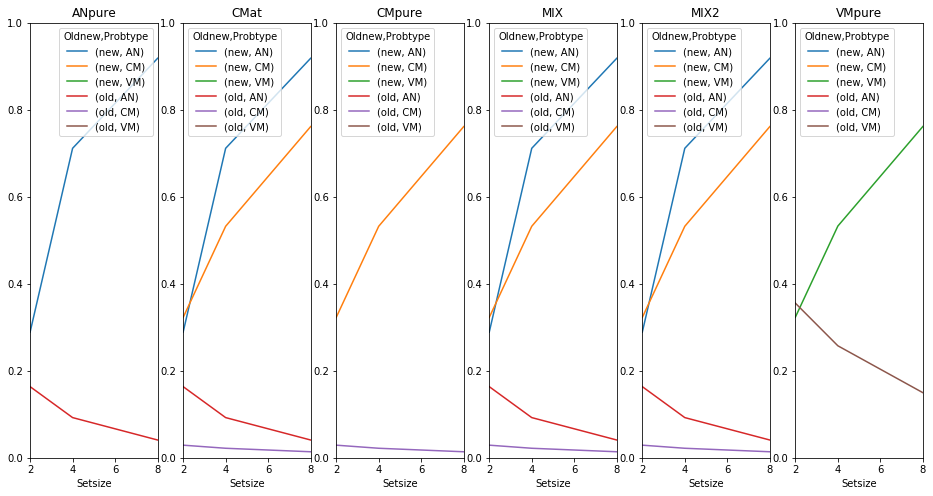

In [30]:
assign_value=1
if assign_value == 1:
    [alpha["all"],
    beta["all"],
    s["all"],
    c,
    Old_crit,
    New_crit,
    t0,
    kao,
    F["CM_oldiold_oldinew"],
    L["CM_oldiold_newinew"],
    L["CM_oldinew_newiold"],
    F["AN_oldiold_oldinew"]]=[
    0.3,
    0.2,
    0.250000028640636132,
    0.690640191843181,
    3.999999835304936,
    -2.194458887105686,
    699.0,
    37.0,
    0.9785718066582388,
    0.9899999996042117,
    0.01,
    0.01]
# print(L["CM_oldinew_newiold"])
df_all_crt, df_all_err = finalRW(df_org)

def all_plot(df_all_aggnew,plotwhaty,ylim):
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16,8))
    fig.canvas.set_window_title(plotwhaty)
    line_width = 2.5
    i=0
    names = df_all_aggnew["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    for iname in names:
        df_all_aggnew[df_all_aggnew["FileCondi"]==iname].plot.line(x="Setsize", y=plotwhaty,ax=axes[i],\
                                                                   title=iname,ylim=ylim )
        i+=1

# all_plot(df_all_aggnew, "RT",(600,1100))
# all_plot(df_all_aggnew, "pred_rt",(600,1100))
# all_plot(df_all_aggnew, "Error",(0,0.3))
# all_plot(df_all_aggnew, "pred_error",(0,1))

df_all_agg = df_all_err.groupby(["Oldnew","Setsize","Probtype","FileCondi"]).agg(["mean"])#.apply(lambda x: x)
df_all_aggnew = df_all_agg.unstack(["Oldnew","Probtype"])
# df_all_aggnew = df_all_agg.unstack(["FileCondi","Oldnew","Probtype"])
df_all_aggnew
# df_all_aggnew= df_all_aggnew.swaplevel(i=0,j=2,axis = 1)

df_all_aggnew.index.name = 'Setsize'
df_all_aggnew.reset_index(inplace=True)


# df_all_aggnew.columns = df_all_aggnew[df_all_aggnew["FileCondi"]==iname].columns.droplevel([1,2])
df_all_aggnew.columns = df_all_aggnew.columns.droplevel([1,2])
# df_all_aggnew


all_plot(df_all_aggnew, "pred_error",(0,1))

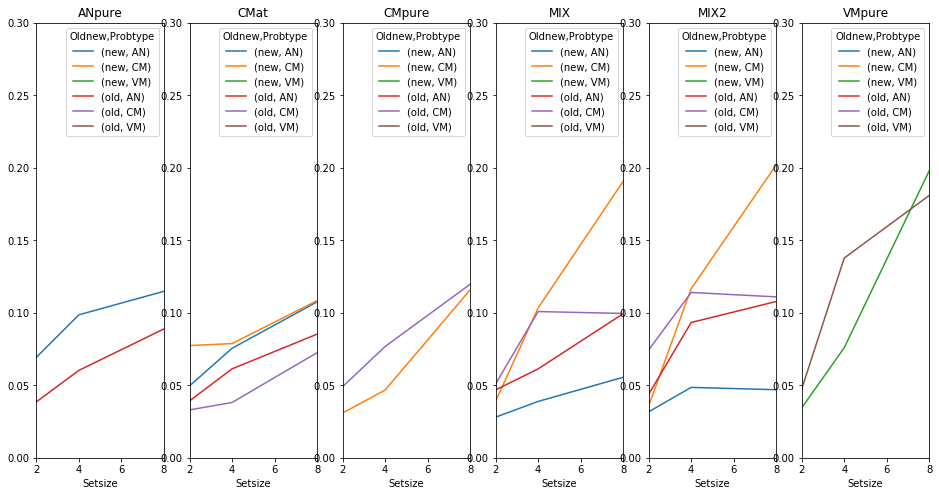

In [27]:
all_plot(df_all_aggnew, "Error",(0,0.3))

## correct RT plot

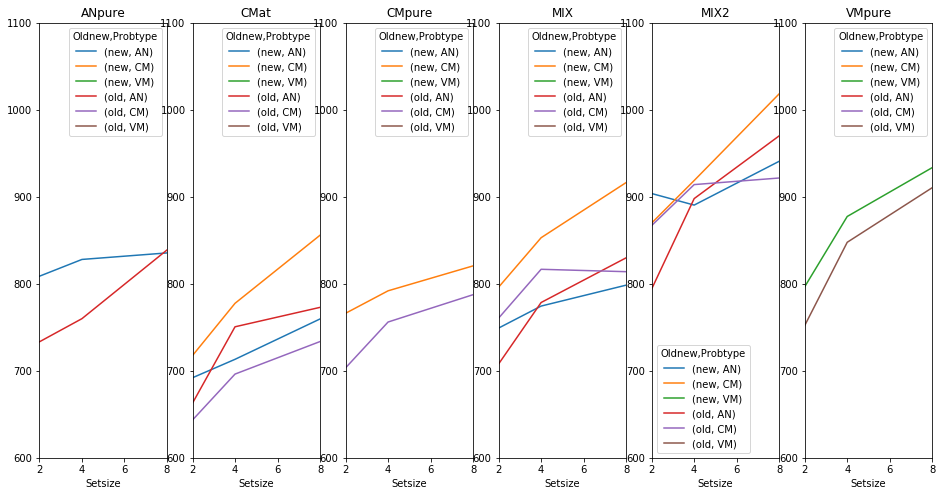

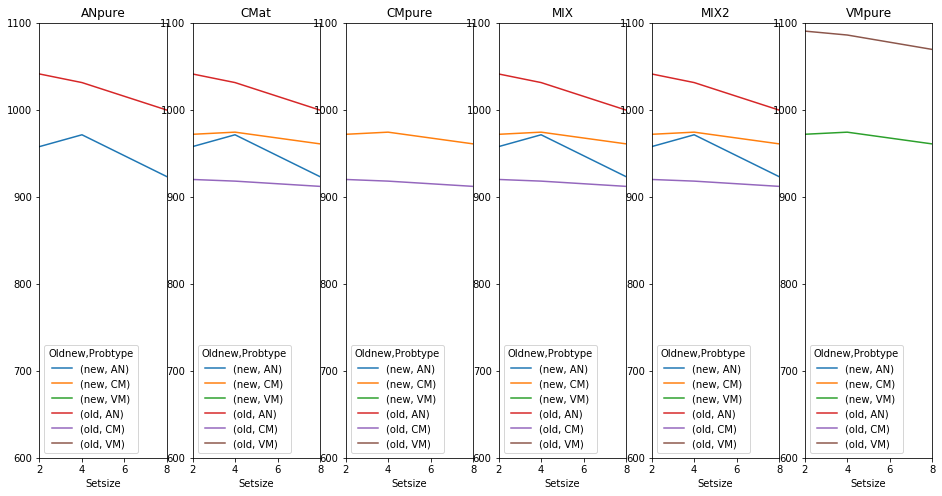

In [28]:
def all_plot(df_all_aggnew,plotwhaty,ylim):
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16,8))
    fig.canvas.set_window_title(plotwhaty)
    line_width = 2.5
    i=0
    names = df_all_aggnew["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    for iname in names:
        df_all_aggnew[df_all_aggnew["FileCondi"]==iname].plot.line(x="Setsize", y=plotwhaty,ax=axes[i],\
                                                                   title=iname,ylim=ylim )
        i+=1

# all_plot(df_all_aggnew, "RT",(600,1100))
# all_plot(df_all_aggnew, "pred_rt",(600,1100))
# all_plot(df_all_aggnew, "Error",(0,0.3))
# all_plot(df_all_aggnew, "pred_error",(0,1))

df_all_agg = df_all_crt.groupby(["Oldnew","Setsize","Probtype","FileCondi"]).agg(["mean"])#.apply(lambda x: x)
df_all_aggnew = df_all_agg.unstack(["Oldnew","Probtype"])
# df_all_aggnew = df_all_agg.unstack(["FileCondi","Oldnew","Probtype"])
df_all_aggnew
# df_all_aggnew= df_all_aggnew.swaplevel(i=0,j=2,axis = 1)

df_all_aggnew.index.name = 'Setsize'
df_all_aggnew.reset_index(inplace=True)


df_all_aggnew.columns = df_all_aggnew.columns.droplevel([1,2])
# df_all_aggnew

all_plot(df_all_aggnew, "RT",(600,1100))
all_plot(df_all_aggnew, "pred_rt",(600,1100))